In [7]:
# Hydraulic Model(s)

## Jain friction factor
def fricf(ks,Re,D):
    import math
    temp1 = ks/(3.7*D)
    temp2 = 5.74/(Re**0.9)
    temp3 = (math.log10(temp1+temp2))**2
    fricf = 0.25/temp3
    return fricf

## Reynolds Number for Circular conduit
def reynolds(Q,D,nu):
    import math
    reynolds = 4*Q*D/(math.pi*nu*D**2)
    return reynolds
    



## Pump Head
def addedHead(dz,L,D,ff,Q,gee):
    import math
    temp1 = (1+ff*L/D)
    temp2 = 16/((math.pi**2)*(D**4)*2*gee)
    addedHead = dz + temp1*temp2*Q**2
    return addedHead

deltaz = 0.784 #meters
Q = 0.0066/1000 #m3/sec
dz = 0.784 #meters
L = 1.0 #meters
D = 0.006 #meters
ks = 0.000007 #meters (table lookup) 
nu = 1.06e-6 #m^2/s (table lookup)
gee = 9.81 #m/s2
#
Re = reynolds(Q,D,nu)
ff = fricf(ks,Re,D)
TDH = addedHead(dz,L,D,ff,Q,gee)
print(TDH)

0.8147227183888511


In [ ]:
import math
import pandas as pd
from pathlib import Path

# --- Constants (adjust as needed) ---
KS  = 7.0e-6     # pipe roughness [m]  (from your table lookup)
NU  = 1.06e-6    # kinematic viscosity [m^2/s]
D   = 0.006      # pipe diameter [m]
L   = 1.0        # pipe length [m]
G   = 9.81       # gravity [m/s^2]


# Jain friction factor
def fricf(ks, Re, D):
    temp1 = ks / (3.7 * D)
    temp2 = 5.74 / (Re ** 0.9)
    temp3 = (math.log10(temp1 + temp2)) ** 2
    return 0.25 / temp3


# Reynolds number for circular conduit
def reynolds(Q, D, nu):
    # Q in m^3/s
    return 4 * Q / (math.pi * nu * D)


# Pump head added by pump
def added_head(dz, L, D, ff, Q, g):
    # dz is static elevation change [m]
    # Q is m^3/s
    temp1 = (1 + ff * L / D)
    temp2 = 16 / ((math.pi ** 2) * (D ** 4) * 2 * g)
    return dz + temp1 * temp2 * Q ** 2


In [ ]:
def compute_tdh_row(row):
    """
    row: a pandas Series with fields
         'Q (LPS)' and 'DH (z2-z1)'
    returns: TDH [m] for that row
    """
    # 1. Extract inputs
    q_lps = row["Q (LPS)"]     # L/s
    dz    = row["DH (z2-z1)"]  # m (already in meters per your note)

    # 2. Convert Q to m^3/s
    Q = q_lps / 1000.0

    # 3. Hydraulics
    Re = reynolds(Q, D, NU)
    ff = fricf(KS, Re, D)
    tdh = added_head(dz, L, D, ff, Q, G)

    return tdh


def process_table(input_path, output_path):
    input_path = Path(input_path)
    output_path = Path(output_path)

    # Read the table; your example looks tab/space separated
    df = pd.read_csv(input_path, delim_whitespace=True)

    # Sanity check: rename columns if you like cleaner names
    # (optional, but sometimes nicer)
    # df.columns = ["Q_LPS", "DH_m"]

    # Compute TDH for each row
    df["TDH (m)"] = df.apply(compute_tdh_row, axis=1)

    # Save result: now has 3 columns:
    #   Q (LPS), DH (z2-z1), TDH (m)
    df.to_csv(output_path, index=False)

    # Optional: print first few rows
    print(df.head().to_string(index=False))


if __name__ == "__main__":
    # Change filenames as you like
    process_table("pump_data.txt", "pump_results.csv")


Fitted model: TDH = 0.888 - 317137.720·Q^3.032


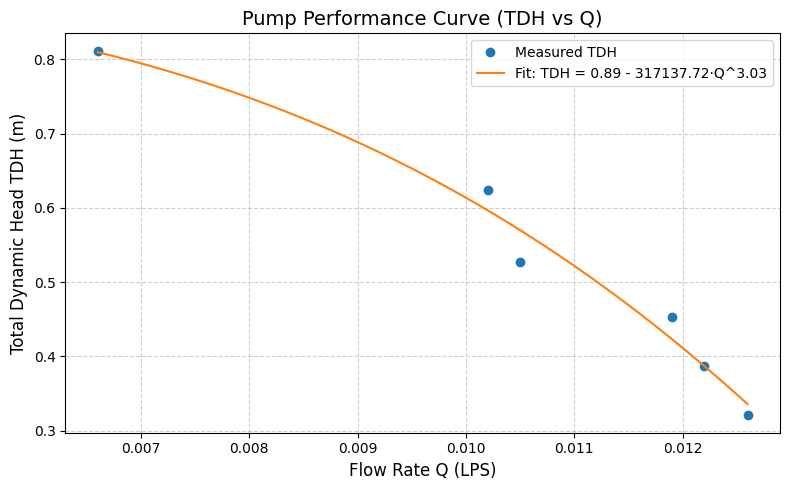

 Q (LPS)  DH (z2-z1)  V(V)  I(A)  P(W)  TDH (m)
  0.0066        0.78   4.0  0.17 0.680 0.810723
  0.0102        0.56   5.5  0.65 3.575 0.623841
  0.0105        0.46   5.5  0.65 3.575 0.527063
  0.0119        0.37   5.5  0.65 3.575 0.453005
  0.0122        0.30   5.5  0.65 3.575 0.386614


In [31]:
import math
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.optimize import curve_fit   # pip install scipy if needed


# --------- CONSTANTS (edit as needed) ---------
KS  = 7.0e-6     # pipe roughness [m] (your table lookup)
NU  = 1.06e-6    # kinematic viscosity [m^2/s]
D   = 0.006      # pipe diameter [m]
L   = 1.0        # pipe length [m]
G   = 9.81       # gravity [m/s^2]


# --------- HYDRAULIC FUNCTIONS ---------
def fricf(ks, Re, D):
    """Jain friction factor."""
    temp1 = ks / (3.7 * D)
    temp2 = 5.74 / (Re ** 0.9)
    temp3 = (math.log10(temp1 + temp2)) ** 2
    return 0.25 / temp3


def reynolds(Q, D, nu):
    """Reynolds number for circular conduit.
    Q in m^3/s.
    """
    return 4.0 * Q / (math.pi * nu * D)


def added_head(dz, L, D, ff, Q, g):
    """Pump total dynamic head added."""
    temp1 = (1.0 + ff * L / D)
    temp2 = 16.0 / ((math.pi ** 2) * (D ** 4) * 2.0 * g)
    return dz + temp1 * temp2 * Q ** 2


# --------- ROW-WISE TDH COMPUTATION ---------
def compute_tdh_row(row):
    """
    Expects columns:
      'Q (LPS)'   – flow in L/s
      'DH (z2-z1)'– elevation difference in m
    Returns TDH [m] for that row.
    """
    q_lps = row["Q (LPS)"]      # L/s
    dz    = row["DH (z2-z1)"]   # m

    # Convert L/s -> m^3/s
    Q = q_lps / 1000.0

    # Hydraulics
    Re  = reynolds(Q, D, NU)
    ff  = fricf(KS, Re, D)
    tdh = added_head(dz, L, D, ff, Q, G)

    return tdh

import matplotlib.pyplot as plt

def plot_tdh_curve(df, output_file="tdh_curve.png"):
    # Sort for nicer plotting
    df_sorted = df.sort_values("Q (LPS)")

    Q_data  = df_sorted["Q (LPS)"].values
    TDH_data = df_sorted["TDH (m)"].values

    # Fit the model
    shutoff, K, exponent = fit_tdh_model(df_sorted)

    # Generate smooth curve for the fitted model
    Q_fit = np.linspace(Q_data.min(), Q_data.max(), 200)
    TDH_fit = tdh_model(Q_fit, shutoff, K, exponent)

    plt.figure(figsize=(8, 5))

    # Measured data
    plt.plot(Q_data, TDH_data, "o", label="Measured TDH")

    # Fitted model
    plt.plot(Q_fit, TDH_fit, "-", label=f"Fit: TDH = {shutoff:.2f} - {K:.2f}·Q^{exponent:.2f}")

    plt.xlabel("Flow Rate Q (LPS)", fontsize=12)
    plt.ylabel("Total Dynamic Head TDH (m)", fontsize=12)
    plt.title("Pump Performance Curve (TDH vs Q)", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()


def tdh_model(Q, shutoff, K, exponent):
    """Model: TDH(Q) = shutoff - K * Q**exponent."""
    return shutoff - K * (Q ** exponent)


def fit_tdh_model(df):
    df_clean = df.dropna(subset=["Q (LPS)", "TDH (m)"])
    Q = df_clean["Q (LPS)"].values
    TDH = df_clean["TDH (m)"].values

    shutoff0  = TDH.max()
    exponent0 = 2.0     # initial guess at the upper bound
    K0        = (shutoff0 - TDH.min()) / (Q.max() ** exponent0)

    popt, pcov = curve_fit(
        tdh_model,
        Q,
        TDH,
        p0=[shutoff0, K0, exponent0],
        bounds=([0, 0, 0], [np.inf, np.inf, 5.0])
    )

    shutoff, K, exponent = popt
    print(f"Fitted model: TDH = {shutoff:.3f} - {K:.3f}·Q^{exponent:.3f}")
    return shutoff, K, exponent


# --------- TABLE INGEST / OUTPUT ---------
def process_table(input_path, output_path):
    input_path = Path(input_path)
    output_path = Path(output_path)

    # Your sample is tab-separated; delim_whitespace=True will also work
    df = pd.read_csv(input_path, sep=",")

    # Fill / overwrite the TDH column
    df["TDH (m)"] = df.apply(compute_tdh_row, axis=1)

    # Write full table back out
    df.to_csv(output_path, sep=",", index=False)

    # --- Plot TDH vs Q ---
    plot_tdh_curve(df)

    # Optional: show first few rows in the console
    print(df.head().to_string(index=False))


if __name__ == "__main__":
    # Change filenames as needed
    process_table("pump_data.csv", "pump_data_with_TDH.csv")


Enter b0 value 0
Enter b1 value 1.27
Enter b2 value 0.5


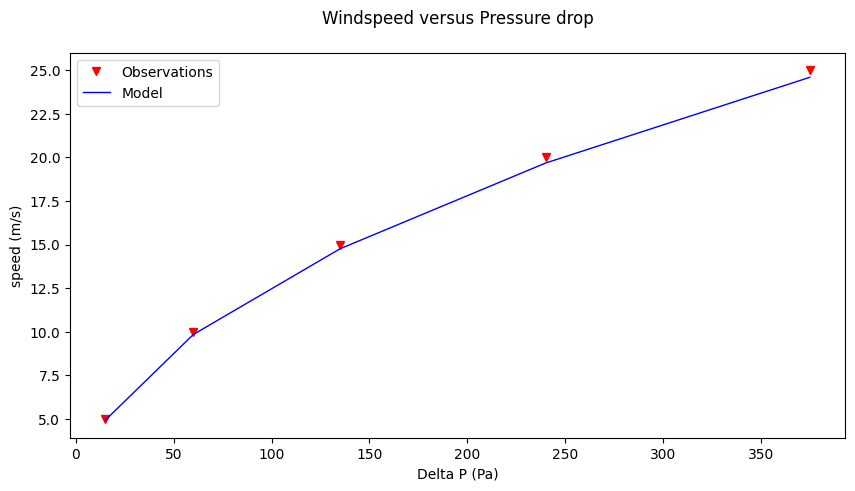

In [12]:
import matplotlib.pyplot as plt
def make2plot(listx1,listy1,listx2,listy2,strlablx,strlably,strtitle):
    mydata = plt.figure(figsize = (10,5)) # build a square drawing canvass from figure class
    plt.plot(listx1,listy1, c='red', marker='v',linewidth=0) # basic data plot
    plt.plot(listx2,listy2, c='blue',linewidth=1) # basic model plot
    plt.xlabel(strlablx)
    plt.ylabel(strlably)
    plt.legend(['Observations','Model'])# modify for argument insertion
    plt.title(strtitle)
    plt.show()
    return

def linear(b0,b1,x):
    ''' 
    linear data model, b0,b1 are parameters
    return y = b0+b1*x
    '''
    linear=b0+b1*x
    return(linear)

def quadratic(b0,b1,b2,x):
    ''' 
    quadratic data model, b0,b1 are parameters
    return y = b0+b1*x+b2*x^2
    '''
    quadratic=b0+b1*x+b2*x**2
    return(quadratic)  

def powerlaw(b0,b1,b2,x):
    '''
    power law data model
    return y = b0 + b1*x**b2'''
    powerlaw=b0+b1*x**b2
    return(powerlaw)

def residue(list1,list2,list3):
    ''' 
    compute residues
    list3 = list1 - list2
    return residuals in list3
    '''
    if len(list1)!=len(list2) or len(list1)!=len(list3):
        print('Lists unequal length, undefined operations')
        return
    for i in range(len(list1)):
        list3[i]=list1[i]-list2[i]
    return(list3)



ytable = [5,10,15,20,25] # nominal windspeed
xtable = [15,60,135,240,375] #pressure drop in pitot tube


# Fit a data model - linear model
b0=float(input('Enter b0 value'))
b1=float(input('Enter b1 value'))
b2=float(input('Enter b2 value'))
# build a data model
modelYYY = [] # empty list
for i in range(len(xtable)):
    modelYYY.append(powerlaw(b0,b1,b2,xtable[i]))
# Plotting results
make2plot(xtable,ytable,xtable,modelYYY,'Delta P (Pa)','speed (m/s)','Windspeed versus Pressure drop\n ')

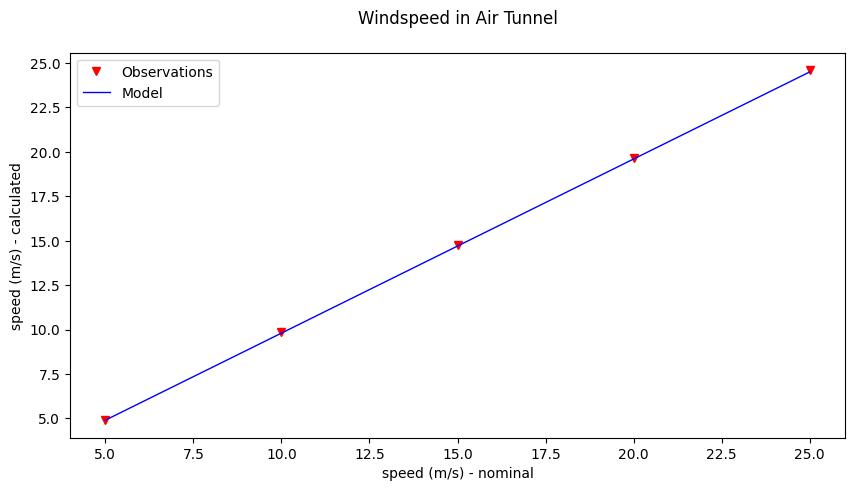

In [21]:
# build a data model
modelZZZ = [] # empty list
for i in range(len(ytable)):
    modelZZZ.append(linear(0,0.98,ytable[i])) # fitted velocity pitot vs velocity nominal
make2plot(ytable,modelYYY,ytable,modelZZZ,'speed (m/s) - nominal','speed (m/s) - calculated','Windspeed in Air Tunnel\n ')